In [3]:
!pip install pyarrow
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import seaborn as sns

Defaulting to user installation because normal site-packages is not writeable


In [4]:
#yt_metadata for all videos from the "radicalization" channels:
videos_radic_df = pd.read_csv("yt_metadata_reduced_radic.tsv.gz")
videos_radic_df.head(5)

/tmp/ipykernel_110/865404904.py:2: DtypeWarning: Columns (4,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  videos_radic_df = pd.read_csv("yt_metadata_reduced_radic.tsv.gz")


,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:47:10.520209,👕 Order your shirts here: https://Teespring.co...,195.0,MBgzne7djFU,378,47027.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Elizabeth Warren Gets a Big Surprise at the Ai...,2019-10-03 00:00:00,374711.0
1,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:16.481889,👕 Order your shirts here: https://Teespring.co...,114.0,AbH3pJnFgY8,278,36384.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",No More Twitter? 😂,2019-10-02 00:00:00,245617.0
2,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:17.137786,👕 Order your shirts here: https://Teespring.co...,143.0,QBuwj_h1SH4,385,40597.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",The Only Thing Stopping Them 😂,2019-10-01 00:00:00,299535.0
3,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:17.823119,👕 Order your shirts here: https://Teespring.co...,193.0,Reogq26-KpI,419,42658.0,"Funny,Entertainment,Fun,Laughing,Educational,L...",Speaking of Losers...,2019-09-30 00:00:00,357126.0
4,News & Politics,UCzUV5283-l5c0oKRtyenj6Q,2019-11-22 08:46:18.497042,👕 Order your shirts here: https://Teespring.co...,136.0,uBY9OtlSnX8,414,44246.0,"Funny,Entertainment,Laughing,Educational,Learn...",The Circus Continues!,2019-09-27 00:00:00,297704.0


In [5]:
#get all unique political orientations
channels_radic_df=pd.read_csv("radic.csv")

In [6]:
#categorize each of the channels (created a respective column "pol_orient")

#note that we dont categorize "Intellectual Dark Web", since it has supporters from left and right
right = ["Alt-lite", "Alt-right", "Incel", "MGTOW", "MRA", "right"]
left  = ["left"]

def pol_orientation(x):
    if x in right: 
        return "right"
    elif x in left:
        return "left"
    else:
        return 0
        
        
channels_radic_df["pol_orient"] = channels_radic_df.Category.apply(pol_orientation)

In [7]:
#match the pol_orient to the videos based on its channel
#takes a bit to run (~2 minutes)
def orient_match(x):
    var = channels_radic_df.loc[channels_radic_df["Id"] == x]["pol_orient"].values
    if len(var) > 0:
        return var[0]
    else:
        return 0

videos_radic_df["pol_orient"] = videos_radic_df["channel_id"].apply(orient_match)

In [8]:
# drop empty rows (--> here you could also drop other rows if the contain un-important words)
videos_radic_df = videos_radic_df[videos_radic_df.title != ""]
videos_radic_df = videos_radic_df[videos_radic_df.pol_orient != 0]

In [9]:
# In this section, we will analyse the sentiment that accompained the use of certain 
# keywords in the videos of right and left political orienatation
import os 
!pip install transformers
!pip3 install emoji==0.6.0
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis","finiteautomata/bertweet-base-sentiment-analysis",
 truncation=True,
   device='cpu',
   batch_size=64,
   num_workers=16)

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [11]:
#def sent_analysis(desc):
    out = sentiment_pipeline(desc)
    return out

#def output(df):
    out = sent_analysis(df['title'].to_list())
    sentiment = pd.DataFrame.from_dict(out)
    df = df.set_index(sentiment.index)
    df = df.join(sentiment['label'])
    df = df.join(sentiment['score'])
    df['label'] = df['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
    df['score'] = df['label']*df['score']
    return df

In [83]:
#climate_df = videos_radic_df[videos_radic_df.title.str.contains('climate change')]
#climate_df= output(climate_df)

#health_df = videos_radic_df[videos_radic_df.title.str.contains('health care')]
#health_df = output(health_df)

#immig_df = videos_radic_df[videos_radic_df.title.str.contains('immigration','immigrant')]
#immig_df = output(immig_df)

#woman_df = videos_radic_df[videos_radic_df.title.str.contains('woman','women')]
#woman_df = output(woman_df)

#abortion_df = videos_radic_df[videos_radic_df.title.str.contains('abortion')]
#abortion_df = output(abortion_df)
                                                              
#war_df = videos_radic_df[videos_radic_df.title.str.contains('war')]
#war_df = output(war_df)                                                              


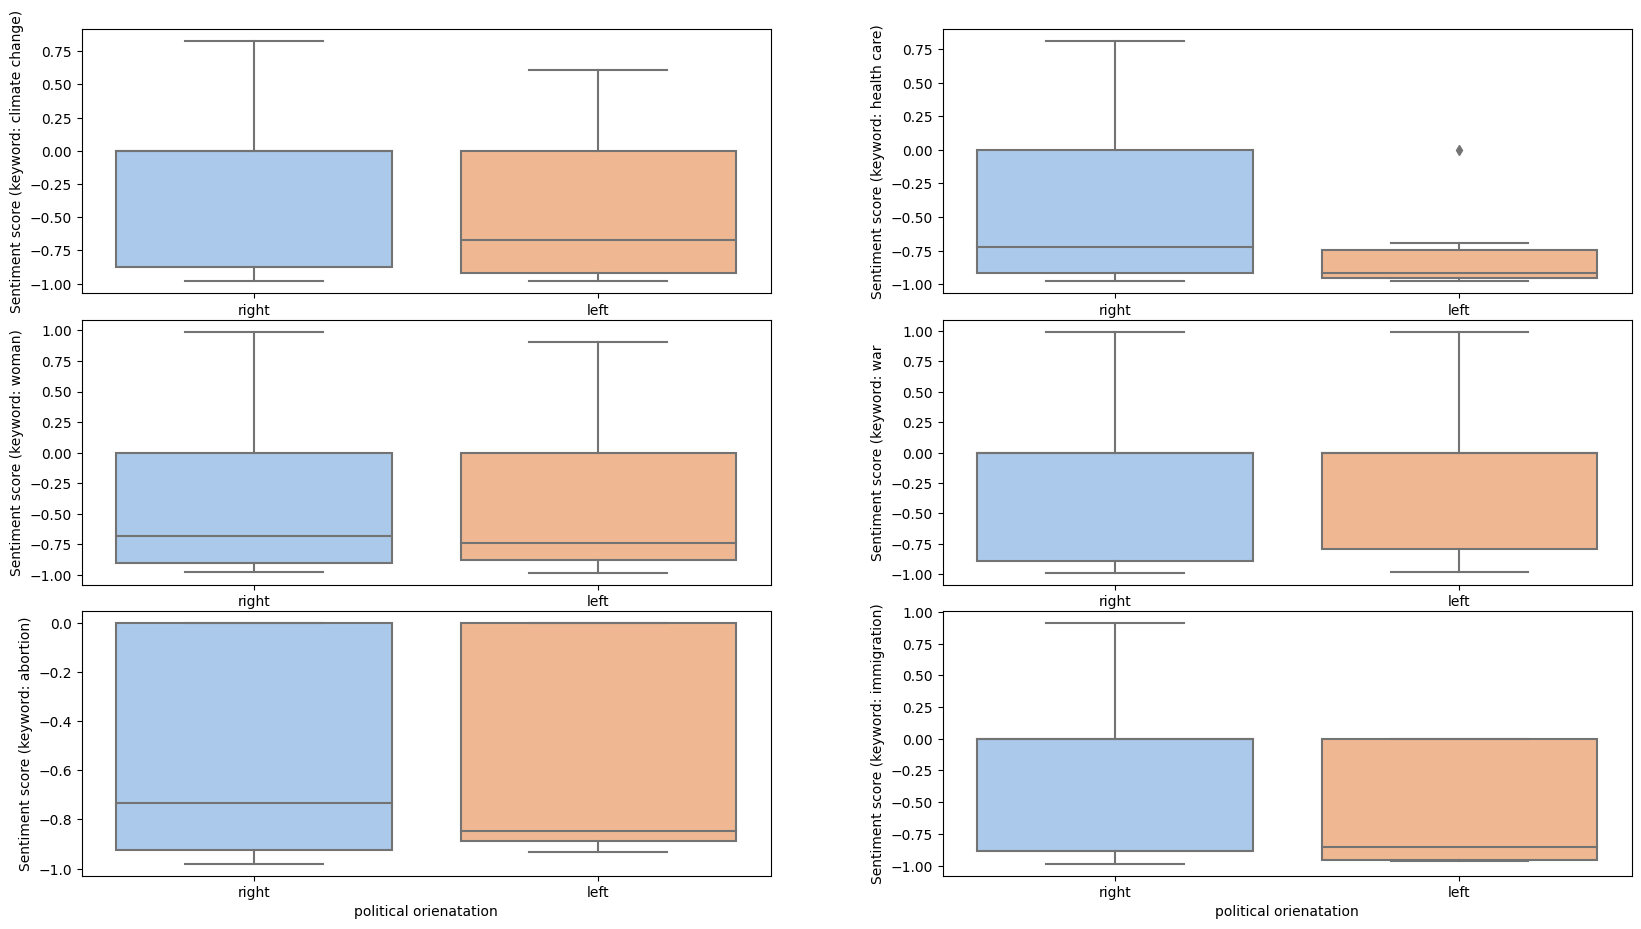

In [84]:
#fig, ((ax1, ax2), (ax3, ax4), (ax5,ax6)) = plt.subplots(3,2, figsize=(20,11),gridspec_kw={"wspace": 0.25, "hspace": 0.1})

#ax1 = sns.boxplot(ax = ax1, data=climate_df, x = climate_df['pol_orient'], y = climate_df['score'], palette="pastel")
#ax1.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: climate change)')
#ax2 = sns.boxplot(ax = ax2, data = health_df, x = health_df['pol_orient'], y = health_df['score'], palette="pastel")
#ax2.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: health care)')
#ax3 = sns.boxplot(ax = ax3, data = woman_df, x = woman_df['pol_orient'], y = woman_df['score'], palette="pastel")
#ax3.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: woman)')
#ax4 = sns.boxplot(ax = ax4, data = war_df, x = war_df['pol_orient'], y = war_df['score'], palette="pastel")
#ax4.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: war')
#ax5 = sns.boxplot(ax = ax5, data = abortion_df, x = abortion_df['pol_orient'], y = abortion_df['score'], palette="pastel")
#ax5.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: abortion)')
#ax6 = sns.boxplot(ax = ax6, data = immig_df, x = immig_df['pol_orient'], y = immig_df['score'], palette="pastel")
#ax6.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: immigration)')

#plt.show()

In [16]:
def sent_analysis(desc):
    out = sentiment_pipeline(desc)
    return out

def output(df):
    out = sent_analysis(df['description'].to_list())
    sentiment = pd.DataFrame.from_dict(out)
    df = df.set_index(sentiment.index)
    df = df.join(sentiment['label'])
    df = df.join(sentiment['score'])
    df['label'] = df['label'].map({'POS': 1.,'NEU':0., 'NEG': -1.})
    df['score'] = df['label']*df['score']
    return df

In [30]:
#videos_df = videos_radic_df[['pol_orient', 'description']]
#climate_df = videos_df[videos_radic_df.description.str.contains('climate change',na=False)]
#climate_df= output(climate_df)

#health_df = videos_df[videos_radic_df.description.str.contains('health care',na=False)]
#health_df = output(health_df)

#immig_df = videos_df[videos_radic_df.description.str.contains('immigration','immigrant',na=False)]
#immig_df = output(immig_df)

#woman_df = videos_df[videos_radic_df.description.str.contains('woman','women',na=False)]
#woman_df = output(woman_df)

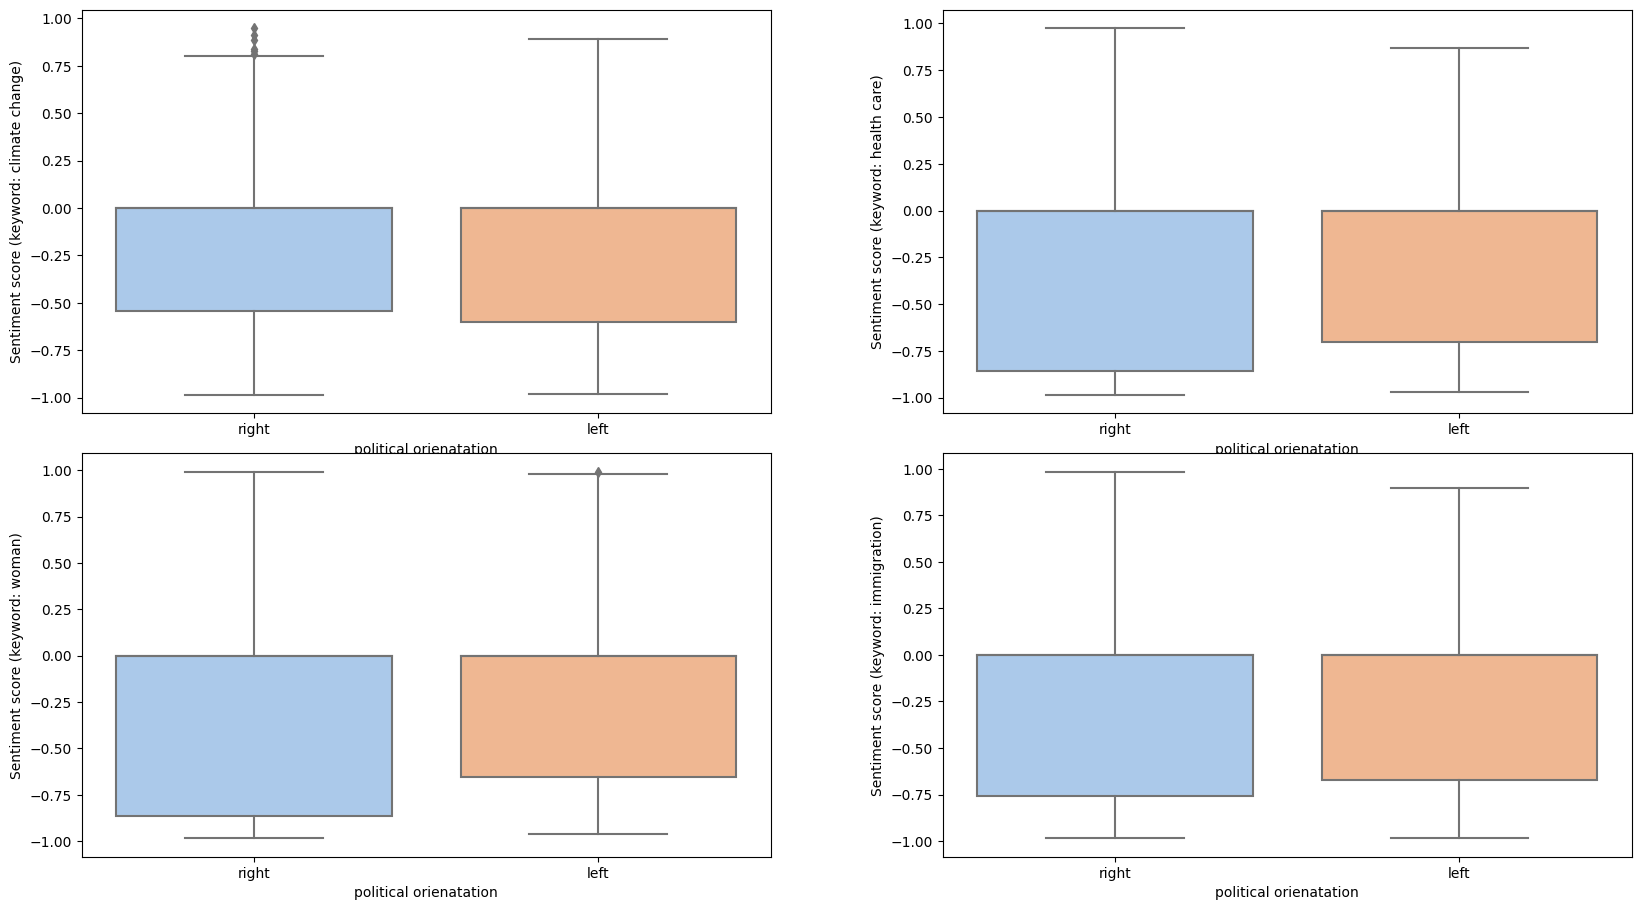

In [32]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2,2, figsize=(20,11),gridspec_kw={"wspace": 0.25, "hspace": 0.1})

ax1 = sns.boxplot(ax = ax1, data=climate_df, x = climate_df['pol_orient'], y = climate_df['score'], palette="pastel")
ax1.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: climate change)')
ax2 = sns.boxplot(ax = ax2, data = health_df, x = health_df['pol_orient'], y = health_df['score'], palette="pastel")
ax2.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: health care)')
ax3 = sns.boxplot(ax = ax3, data = woman_df, x = woman_df['pol_orient'], y = woman_df['score'], palette="pastel")
ax3.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: woman)')
ax4 = sns.boxplot(ax = ax4, data = immig_df, x = immig_df['pol_orient'], y = immig_df['score'], palette="pastel")
ax4.set(xlabel='political orienatation', ylabel='Sentiment score (keyword: immigration)')
plt.show()

In [33]:
# Create a new column --> binary variable = 0 in case of left wing, = 1 in case of right wing 
climate_df['is_right'] = np.where((climate_df['pol_orient'] == "right"), 1, 0)
health_df['is_right'] = np.where((health_df['pol_orient'] == "right"), 1, 0)
immig_df['is_right'] = np.where((immig_df['pol_orient'] == "right"), 1, 0)
woman_df['is_right'] = np.where((woman_df['pol_orient'] == "right"), 1, 0)

In [35]:
# Linear Regression (y --> sentiement score , x --> binary variable to indicate the political orientation)  
# Declares the model y = beta_0 + beta_1 * (is_right)
import statsmodels.api as sm
import statsmodels.formula.api as smf

mod = smf.ols(formula='score ~ C(is_right)', data=climate_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.087
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.298
Time:                        10:23:39   Log-Likelihood:                -373.99
No. Observations:                 666   AIC:                             752.0
Df Residuals:                     664   BIC:                             761.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2051      0.023  

In [36]:
# Declares the model y = beta_0 + beta_1 * (is_right)
mod = smf.ols(formula='score ~ C(is_right)', data=health_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     2.003
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.159
Time:                        10:23:53   Log-Likelihood:                -142.66
No. Observations:                 197   AIC:                             289.3
Df Residuals:                     195   BIC:                             295.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2133      0.072  

In [37]:
# Declares the model y = beta_0 + beta_1 * (is_right)
mod = smf.ols(formula='score ~ C(is_right)', data=immig_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.975
Date:                Thu, 22 Dec 2022   Prob (F-statistic):              0.160
Time:                        10:24:00   Log-Likelihood:                -632.77
No. Observations:                 990   AIC:                             1270.
Df Residuals:                     988   BIC:                             1279.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.2655      0.026  

In [38]:
# Declares the model y = beta_0 + beta_1 * (is_right)
mod = smf.ols(formula='score ~ C(is_right)', data=woman_df)
# Fits the model (find the optimal coefficients, adding a random seed ensures consistency)
np.random.seed(2)
res = mod.fit()
# Print thes summary output provided by the library.
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  score   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     9.413
Date:                Thu, 22 Dec 2022   Prob (F-statistic):            0.00219
Time:                        10:24:23   Log-Likelihood:                -1114.7
No. Observations:                1541   AIC:                             2233.
Df Residuals:                    1539   BIC:                             2244.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.1974      0.028  